# Preface

I updated the challenges slightly.

<center>
<h1>Chapter Four</h1>
</center>

<hr>

## LEARNING OBJECTIVES:
- Semi-deep dive into the wrangling of outliers in your data. Introduce a set of alternative methods to consider.
- Capture several in custom Transformers.
- Place them correctly in Pipeline.

# I. Outliers

We will look at both identifying and handling outliers in a column. I'll introduce 2 different (but related) identification methods. For handling, we will use the same simple method.

Be aware we could also look for entire rows as outliers: [Sample outliers](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html#sklearn.neighbors.LocalOutlierFactor). Interesting, but we will focus on outliers in a single cell in a column.

## Set-up

First bring in your library.

In [58]:
github_name = 'smith'
repo_name = 'mlops'
source_file = 'library.py'
url = f'https://raw.githubusercontent.com/{github_name}/{repo_name}/main/{source_file}'
# !rm $source_file
# !wget $url
# %run -i $source_file
from library import *

## Make sure transformers from chapter 3 are in your library

In [59]:
type(CustomMappingTransformer), type(CustomOHETransformer)  #(type, type)

(type, type)

## Now titanic dataset

In [60]:

url = 'https://raw.githubusercontent.com/fickas/asynch_models/refs/heads/main/datasets/titanic_trimmed.csv'

titanic_table = pd.read_csv(url)  #using our new package to read in an entire dataset - the coolest

In [61]:
titanic_table.head()  #print first 5 rows of the table

,Age,Gender,Class,Joined,Married,Fare,Survived
0,41.0,Male,C3,Southampton,0.0,7.0,0
1,21.0,Male,Crew,Southampton,0.0,0.0,0
2,13.0,Male,C3,Southampton,NaN,20.0,0
3,16.0,Male,C3,Southampton,0.0,NaN,0
4,NaN,Male,C2,Cherbourg,0.0,24.0,0


## Remove label column

In [62]:
titanic_features = titanic_table.drop(columns='Survived')

## Wrangle using your pipeline

Should be in your library.

In [63]:
transformed_df = titanic_transformer.fit_transform(titanic_features)

[Pipeline] ............ (step 1 of 3) Processing gender, total=   0.0s


[Pipeline] ............. (step 2 of 3) Processing class, total=   0.0s
[Pipeline] ............ (step 3 of 3) Processing joined, total=   0.0s


In [64]:
transformed_df.head()

,Age,Gender,Class,Married,Fare,Joined_Belfast,Joined_Cherbourg,Joined_Queenstown,Joined_Southampton
0,41.0,0,1.0,0.0,7.0,0,0,0,1
1,21.0,0,0.0,0.0,0.0,0,0,0,1
2,13.0,0,1.0,NaN,20.0,0,0,0,1
3,16.0,0,1.0,0.0,NaN,0,0,0,1
4,NaN,0,2.0,0.0,24.0,0,1,0,0


# II. Wrangle outliers
<img src='https://www.dropbox.com/s/9fcc1crlxp19ijt/major_section.png?raw=1' width='300'>

We spent last week wrangling our string columns into numeric form. In this chapter, we will focus on the numeric columns and look at outliers in those columns.

## The outlier problem

Outliers are data values that are extreme, either on high end or on low end. What is meant by "extreme" depends on the outlier-detection methods we use. We will explore two.

The problem  with outliers are twofold:

1. They may be mistakes. When data was being entered, a typo was made. Looking at the Titanic data, there is a fare of 512. Perhaps that should have been 51.2 but a typo was made. So an outlier might not be a legitimate value.

2. Even if they are legit,
outliers can screw up our prediction models. Some machine learning models will give too much credence to outliers and skew results.

Our goal is to (a) identify outliers, and then (b) transform outliers into a more acceptable form. I am going to use two standard identification approaches called the 3Sigma rule and the Tukey ("two key") rule. However, there are  others to choose from. Here is a start if you are interested: [Variety of outlier methods](https://towardsdatascience.com/detecting-and-treating-outliers-in-python-part-1-4ece5098b755). Here are a few more sophisticated approaches: [More sophisticated outlier methods](https://medium.com/swlh/top-five-methods-to-identify-outliers-in-data-2777a87dd7fe).

# III. The 3 Sigma rule

The first outlier identification we will look at is called 3 Sigma, where Sigma stands for standard deviation. It's relatively simple. Given a column like Fare, find the mean and standard deviation. Set boundaries as follows: low boundary is `mean - 3 * sigma`; the high boundary is `mean + 3 * sigma`.
Values beyond that boundary wall may be considered outliers. So we add, to the mean, 3 times the standard deviation to get the upper boundary and minus 3 times the standard deviation to get the lower boundary.
The lowercase Greek letter mu (µ) represents the mean.

<img src='https://www.dropbox.com/scl/fi/t6ja1id9ybmnol3t0zblb/Screenshot-2025-01-03-at-9.25.18-AM.png?rlkey=t8n52kfd4b015yb6o6h7au587&raw=1' height=300>

<img src='https://www.dropbox.com/s/8x575mvbi1xumje/cash_line.png?raw=1' height=3 width=500><br>
<img src='https://www.gannett-cdn.com/-mm-/56cbeec8287997813f287995de67747ba5e101d5/c=9-0-1280-718/local/-/media/2018/02/15/Phoenix/Phoenix/636542954131413889-image.jpg'
height=50 align=center>


Let's write a function that will compute the low and high boundaries of a column.

Return a tuple of low boundary and high boundary.

Hint: no loops needed if can find correct pandas methods.



In [65]:
# I'll get us started

def compute_3sigma_boundaries(df: pd.DataFrame, column_name: str) -> Tuple[float, float]:
  """Computes the low and high boundaries of a column using the 3 Sigma rule.
  Given a column like Fare, find the mean and standard deviation. Set boundaries as follows:
  low boundary is `mean - 3 * sigma`; the high boundary is `mean + 3 * sigma`.
  Values beyond that boundary wall may be considered outliers.
  The lowercase Greek letter mu (µ) represents the mean.

  Args:
    df: The input DataFrame.
    column_name: The name of the column to compute boundaries for.

  Returns:
    A tuple containing the low and high boundaries.
  """
  assert isinstance(df, pd.core.frame.DataFrame), f'expected Dataframe but got {type(df)} instead.'
  assert column_name in df.columns.to_list(), f'unknown column {column_name}'
  assert pd.api.types.is_numeric_dtype(df[column_name]), f'expected int or float in column {column_name}'


  #your code below

  # Compute the mean and standard deviation of the column
  mean = df[column_name].mean()
  sigma = df[column_name].std()

  # Compute the low and high boundaries
  upper = mean + 3 * sigma
  lower = mean - 3 * sigma

  # Return the boundaries
  return (lower, upper)

## Test on the Fare column

In [66]:
s3min, s3max = compute_3sigma_boundaries(transformed_df, 'Fare')
(s3min,s3max)  #(-126.58295661603658, 188.92587042229135)

(-126.58295661603658, 188.92587042229135)

In [67]:
(transformed_df['Fare'].min(), transformed_df['Fare'].max())  #(0.0, 512.0)

(0.0, 512.0)

### High outliers

Nothing below -126 in fare, but some fares over 189. Let's plot it.

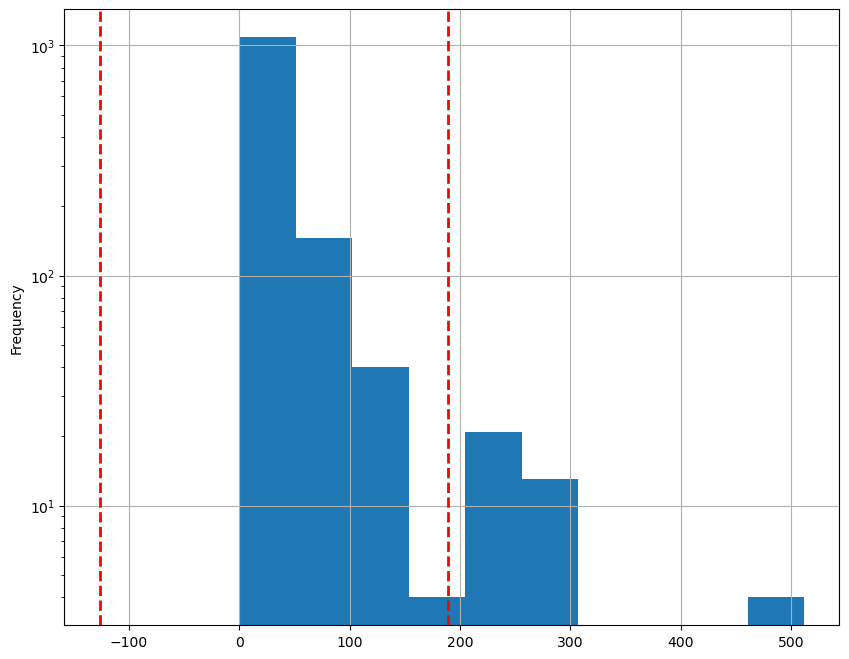

In [68]:
ax = transformed_df['Fare'].plot(kind='hist', figsize=(10,8), grid=True, logy=True)  #what we have seen before
ax.axvline(x=s3min, ymin=0, ymax=1, color='r', linestyle='--', lw=2)  #low fence
ax.axvline(x=s3max, ymin=0, ymax=1, color='r', linestyle='--', lw=2)  #high fence

We can double-check what we see with a couple of pandas methods. For more see here: [skew and kurtosis](https://medium.com/@atanudan/kurtosis-skew-function-in-pandas-aa63d72e20de).

In [69]:
transformed_df['Fare'].skew()  #4.2823355053978585 greater than 1 highly skewed right

4.2823355053978585

In [70]:
transformed_df['Fare'].kurtosis()  #26.020798741121023 greater than 0 = "heavy tails/outliers"

26.020798741121023

It is skewed. And has a heavy tail, meaning lots of values near extremes. I am going to plow ahead with using 3sigma but in reality might be better off  "unskewing" the column before employing 3Sigma, e.g., [skew handling](https://towardsdatascience.com/top-3-methods-for-handling-skewed-data-1334e0debf45).

### Let's try Age

In [71]:
s3min, s3max = compute_3sigma_boundaries(transformed_df, 'Age')
(s3min,s3max)  #(-11.466448491618326, 74.6152214977533)

(-11.466448491618326, 74.6152214977533)

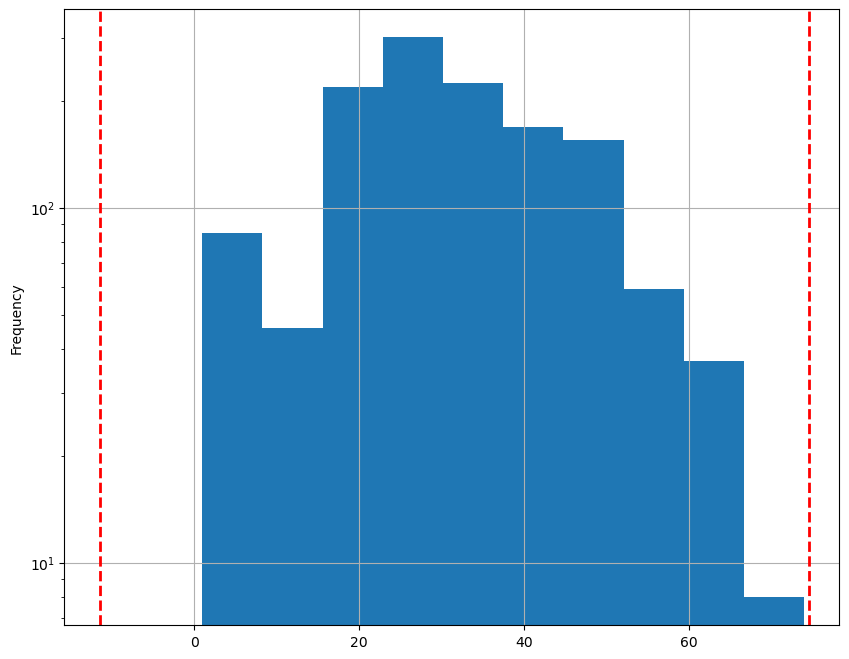

In [72]:
ax = transformed_df['Age'].plot(kind='hist', figsize=(10,8), grid=True, logy=True)
ax.axvline(x=s3min, ymin=0, ymax=1, color='r', linestyle='--', lw=2)  #low fence
ax.axvline(x=s3max, ymin=0, ymax=1, color='r', linestyle='--', lw=2)  #high fence

In [73]:
# Skewness - see skew method doc for more info

transformed_df['Age'].skew()  #0.14808832680399128 less than 1 much less skew

0.14808832680399128

In [74]:
# Kurtosis - see kurtosis method doc for more info

transformed_df['Age'].kurtosis()  #-0.1815192902344882 close to normal if 0

-0.1815192902344882

# Clip outliers

Ok, we found outliers. Now what? How can we deal with them? I am going to suggest a very easy fix. Move the outliers to the boundary.

pandas has a method `clip` that is handy for what we want to do: move outliers to their boundaries. Check it out.

In [75]:
minb, maxb = compute_3sigma_boundaries(transformed_df, 'Fare')
transformed_df['Clipped_Fare'] = transformed_df['Fare'].clip(lower=minb, upper=maxb)


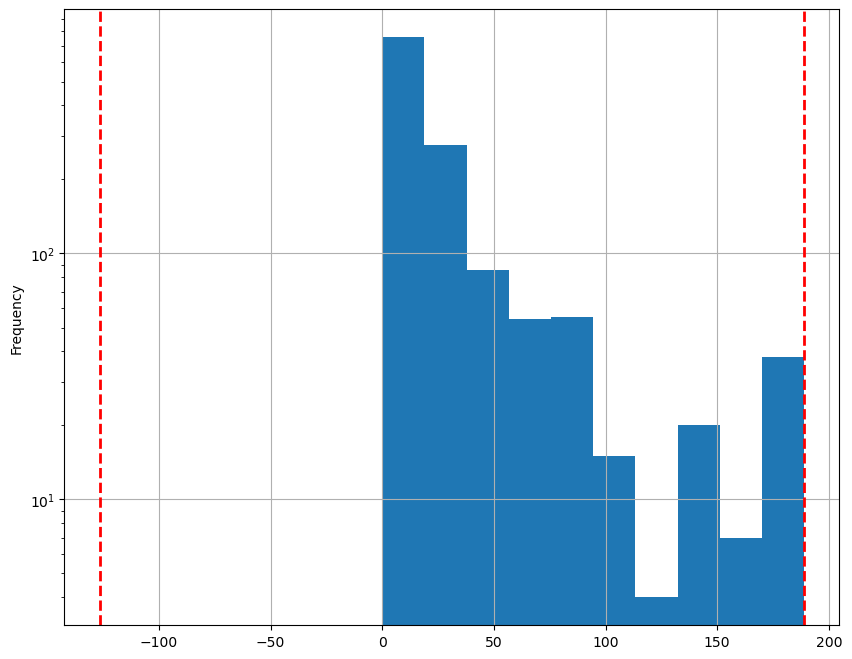

In [76]:
s3min, s3max = compute_3sigma_boundaries(transformed_df, 'Fare')
ax = transformed_df['Clipped_Fare'].plot(kind='hist', figsize=(10,8), grid=True, logy=True)
ax.axvline(x=s3min, ymin=0, ymax=1, color='r', linestyle='--', lw=2)  #low fence
ax.axvline(x=s3max, ymin=0, ymax=1, color='r', linestyle='--', lw=2)  #high fence

# IV. The Tukey (two key) method and the boxplot

Let's assume we do not like the 3Sigma method and want to try an alternative.
In a box plot, introduced by John Tukey in 1970, the data is divided into quartiles. It usually shows a rectangular box representing 25%-75% of a sample’s observations, extended by so-called whiskers that provide a measure of outlierness. Observations shown outside of the whiskers are outliers (explained in more detail below).

What is interesting about Tukey is that he decided to define 2 walls/fences on either side. Items between the fences were viewed as "possible" outliers; items beyond the outer fence were viewed as "probable" outliers. Of course this all depends on the subjective meaning of possible and probable.

## The quartiles (25%, 50%, 75%)

These can be useful for determining the distribution of a column. And also looking for outliers. Let's say I sort the `Age` column into an ascending list. The 25% quartile tells me where I would have to set the value to get 25% of the data below that value (or on the left of the list). There is a pandas method for giving us the values for the quartiles.

In [77]:
transformed_df['Age'].describe()

count    1304.000000
mean       31.574387
std        14.346945
min         1.000000
25%        22.000000
50%        30.500000
75%        41.000000
max        74.000000
Name: Age, dtype: float64

## The boxplot (with modifications)

There is a pandas method, `boxplot`, for plotting some of the Tukey info we need. In particlar, it will give us the inner fences (called whiskers) of Tukey. What we need to add are the outer fences. Then everything between inner and outer is possible outliers and everything beyond outer is probable outliers.

/tmp/ipykernel_198066/3752157709.py:15: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


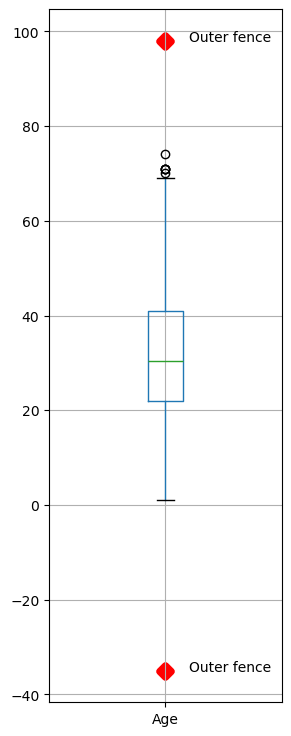

In [78]:
import matplotlib.pyplot as plt
column='Age'
fig, ax = plt.subplots(1,1, figsize=(3,9))
transformed_df.boxplot(column, vert=True, ax=ax, grid=True)  #normal boxplot
#now add on outer fences
q1 = transformed_df[column].quantile(0.25)
q3 = transformed_df[column].quantile(0.75)
iqr = q3-q1
outer_low = q1-3*iqr
outer_high = q3+3*iqr
ax.scatter(1, outer_low, c='red', label='outer_low', marker="D", linewidths=5)
ax.text(1.1,  outer_low, "Outer fence")
ax.scatter(1, outer_high, c='red', label='outer_high', marker="D", linewidths=5)
ax.text(1.1,  outer_high, "Outer fence")
fig.show()

### Rotating 90

<img src='https://miro.medium.com/max/1400/1*2c21SkzJMf3frPXPAR_gZA.png' height=200>

### No probables for `Age`

We have a set of possible points, but nothing beyond outer fences. Let's check out `Fare`.

/tmp/ipykernel_198066/1363532992.py:15: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


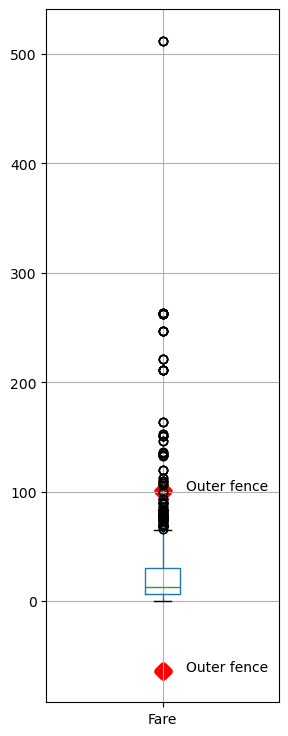

In [79]:
import matplotlib.pyplot as plt
column='Fare'
fig, ax = plt.subplots(1,1, figsize=(3,9))
transformed_df.boxplot(column, vert=True, ax=ax, grid=True)  #normal boxplot
# now add on outer fences
q1 = transformed_df[column].quantile(0.25)
q3 = transformed_df[column].quantile(0.75)
iqr = q3-q1
outer_low = q1-3*iqr
outer_high = q3+3*iqr
ax.scatter(1, outer_low, c='red', label='outer_low', marker="D", linewidths=5)
ax.text(1.1,  outer_low, "Outer fence")
ax.scatter(1, outer_high, c='red', label='outer_high', marker="D", linewidths=5)
ax.text(1.1,  outer_high, "Outer fence")
fig.show()

### Lots of probables for `Fare`

# Challenge 1

Another way to deal with outliers is to remove any row that has an outlier value. Out of sight, out of mind.

Let's say we want to remove all rows who have a value in the `Fare` column that is greater than `outer_high`. I'll create a new dataframe called `clean_titanic` where this is the case.






## Step 1. Create a new table with rows with high **probables** removed

Pandas `query` method should be all you need.

**But important note**: the `query` method will also drop rows with `NaN` values. If you use something other than `query` to drop (e.g., the `drop` method), this may not be the case and you could end up with results slightly different than 1229 - there are two `NaN` values in the `Fare` column so you could get 1231. That's ok too.

### remove
<pre>
clean_titanic = transformed_df.drop(transformed_df[transformed_df.Fare > outer_high].index).reset_index(drop=True)  #1231
</pre>

Here is an alternative solution (you could also use `@outer_high` without f string):

<pre>
clean2_titanic = transformed_df.query(f'Fare <= {outer_high}').reset_index(drop=True)  #2093
</pre>

So it appears that the query method drops the two NaN columns while the drop method retains them. Interesting! I believe most of you were using `.loc` instead of `.query` but getting same results.

For future reference, I would prefer not to drop the rows with NaN values. So when working with rows, use `drop`.
</pre>

In [80]:
transformed_df['Fare'].isna().sum()  #2 NaNs in the column

2

In [81]:
cleaned_titanic = transformed_df.query(f'Fare <= {outer_high}')  #or transformed_df.query('Fare <= @outer_high')
len(cleaned_titanic)   #1229

1229

In [82]:
cleaned_titanic.tail()

,Age,Gender,Class,Married,Fare,Joined_Belfast,Joined_Cherbourg,Joined_Queenstown,Joined_Southampton,Clipped_Fare
1308,4.0,0,1.0,0.0,22.0,0,1,0,0,22.0
1309,2.0,1,1.0,0.0,22.0,0,1,0,0,22.0
1310,23.0,1,1.0,1.0,22.0,0,1,0,0,22.0
1311,22.0,1,3.0,0.0,61.0,0,0,0,1,61.0
1312,27.0,0,1.0,0.0,7.0,0,1,0,0,7.0


## Step 2. Reset index so no gaps



In [83]:
clean2_titanic = cleaned_titanic.reset_index(drop=True)
len(clean2_titanic)  #1229

1229

In [84]:
clean2_titanic.tail()

,Age,Gender,Class,Married,Fare,Joined_Belfast,Joined_Cherbourg,Joined_Queenstown,Joined_Southampton,Clipped_Fare
1224,4.0,0,1.0,0.0,22.0,0,1,0,0,22.0
1225,2.0,1,1.0,0.0,22.0,0,1,0,0,22.0
1226,23.0,1,1.0,1.0,22.0,0,1,0,0,22.0
1227,22.0,1,3.0,0.0,61.0,0,0,0,1,61.0
1228,27.0,0,1.0,0.0,7.0,0,1,0,0,7.0


### What I see

|index|Age|Gender|Class|Married|Fare|Joined\_Belfast|Joined\_Cherbourg|Joined\_Queenstown|Joined\_Southampton|Clipped\_Fare|
|---|---|---|---|---|---|---|---|---|---|---|
|1224|4\.0|0|1\.0|0\.0|22\.0|0|1|0|0|22\.0|
|1225|2\.0|1|1\.0|0\.0|22\.0|0|1|0|0|22\.0|
|1226|23\.0|1|1\.0|1\.0|22\.0|0|1|0|0|22\.0|
|1227|22\.0|1|3\.0|0\.0|61\.0|0|0|0|1|61\.0|
|1228|27\.0|0|1\.0|0\.0|7\.0|0|1|0|0|7\.0|

# Challenge 2

Build a CustomSigma3Transformer and add it to your library. Test it out below. Use `clip` to do transformation on named column.

As with `CustomPearsonTransformer`, the main work should be done by the `fit` method, which computes the two walls. The `transform` method simply clips and resets index.

### First define it in notebook and test

In [85]:
class CustomSigma3Transformer(BaseEstimator, TransformerMixin):
    """
    A transformer that applies 3-sigma clipping to a specified column in a pandas DataFrame.

    This transformer follows the scikit-learn transformer interface and can be used in
    a scikit-learn pipeline. It clips values in the target column to be within three standard
    deviations from the mean.

    Parameters
    ----------
    target_column : Hashable
        The name of the column to apply 3-sigma clipping on.

    Attributes
    ----------
    high_wall : Optional[float]
        The upper bound for clipping, computed as mean + 3 * standard deviation.
    low_wall : Optional[float]
        The lower bound for clipping, computed as mean - 3 * standard deviation.
    """
    def __init__(self, target_column: Hashable):
        self.target_column = target_column
        self.high_wall = None
        self.low_wall = None
    
    def fit(self, X: pd.DataFrame, y: Optional[Iterable] = None) -> Self:
        """
        Fits the transformer by calculating the mean and standard deviation of the target column.

        Parameters
        ----------
        X : pd.DataFrame
            The input DataFrame.
        y : array-like, default=None
            Ignored. Present for compatibility with scikit-learn interface.

        Returns
        -------
        self : CustomSigma3Transformer
            Fitted transformer.

        Raises
        ------
        AssertionError
            If the input DataFrame is not of type pd.DataFrame or if the target column is not in the DataFrame.
            If the target column is not numeric.
        """
        assert isinstance(X, pd.DataFrame), f'expected Dataframe but got {type(X)} instead.'
        assert self.target_column in X.columns.to_list(), f'unknown column {self.target_column}'
        assert pd.api.types.is_numeric_dtype(X[self.target_column]), f'expected int or float in column {self.target_column}'

        mean = X[self.target_column].mean()
        sigma = X[self.target_column].std()

        self.high_wall = mean + 3 * sigma
        self.low_wall = mean - 3 * sigma

        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        """
        Transforms the input DataFrame by clipping the target column to be within the high and low walls.

        Parameters
        ----------
        X : pd.DataFrame
            The input DataFrame to transform.

        Returns
        -------
        X : pd.DataFrame
            The transformed DataFrame with the target column clipped.

        Raises
        ------
        AssertionError
            If the transform method is called before fit.
        """
        assert self.high_wall is not None and self.low_wall is not None, "Transformer has not been fitted yet."
        X[self.target_column] = X[self.target_column].clip(lower=self.low_wall, upper=self.high_wall)
        return X

### Testing

In [87]:
sigma3_transformer = CustomSigma3Transformer('fare')
new_df1 = sigma3_transformer.fit_transform(transformed_df)  #AssertionError: unknown column fare

AssertionError: unknown column fare

In [88]:
sigma3_transformer = CustomSigma3Transformer('Fare')

In [89]:
new_df1 = sigma3_transformer.transform(transformed_df)  #AssertionError: Sigma3Transformer.fit has not been called.

AssertionError: Transformer has not been fitted yet.

In [90]:
new_df1 = sigma3_transformer.fit_transform(transformed_df)
(new_df1['Fare'].min(), new_df1['Fare'].max())  #(0.0, 188.92587042229135)

(0.0, 188.92587042229135)

### Now add to your library.

# Challenge 3

Build a `CustomTukeyTransformer` and add it to your library. Test it out below. Use `clip` to do transformation on named column.

Note that Tukey gives us more options for parameters. In particular, it defines inner and outer fences. Add that. BTW: this is another reason for keeping the 2 transformers separate. It gets messy defining parameters that only make sense for one set of options.

Follow same scheme as with 3sigma: have the `fit` method compute the walls and the `transform` method simply clips and resets index.

### First define it in notebook and test

In [99]:
class CustomTukeyTransformer(BaseEstimator, TransformerMixin):
    """
    A transformer that applies Tukey's fences (inner or outer) to a specified column in a pandas DataFrame.

    This transformer follows the scikit-learn transformer interface and can be used in a scikit-learn pipeline.
    It clips values in the target column based on Tukey's inner or outer fences.

    Parameters
    ----------
    target_column : Hashable
        The name of the column to apply Tukey's fences on.
    fence : Literal['inner', 'outer'], default='outer'
        Determines whether to use the inner fence (1.5 * IQR) or the outer fence (3.0 * IQR).

    Attributes
    ----------
    inner_low : Optional[float]
        The lower bound for clipping using the inner fence (Q1 - 1.5 * IQR).
    outer_low : Optional[float]
        The lower bound for clipping using the outer fence (Q1 - 3.0 * IQR).
    inner_high : Optional[float]
        The upper bound for clipping using the inner fence (Q3 + 1.5 * IQR).
    outer_high : Optional[float]
        The upper bound for clipping using the outer fence (Q3 + 3.0 * IQR).

    Examples
    --------
    >>> import pandas as pd
    >>> df = pd.DataFrame({'values': [10, 15, 14, 20, 100, 5, 7]})
    >>> tukey_transformer = CustomTukeyTransformer(target_column='values', fence='inner')
    >>> transformed_df = tukey_transformer.fit_transform(df)
    >>> transformed_df
    """
    def __init__(self, target_column: Hashable, fence: Literal['inner', 'outer'] = 'outer'):
        self.target_column = target_column
        self.fence = fence
        self.inner_low = None
        self.outer_low = None
        self.inner_high = None
        self.outer_high = None

    def fit(self, X: pd.DataFrame, y: Optional[Iterable] = None) -> Self:
        """
        Fits the transformer by calculating the quartiles and IQR of the target column.

        Parameters
        ----------
        X : pd.DataFrame
            The input DataFrame.
        y : array-like, default=None
            Ignored. Present for compatibility with scikit-learn interface.

        Returns
        -------
        self : CustomTukeyTransformer
            Fitted transformer.

        Raises
        ------
        AssertionError
            If the input DataFrame is not of type pd.DataFrame or if the target column is not in the DataFrame.
            If the target column is not numeric.
        """
        assert isinstance(X, pd.DataFrame), f'expected Dataframe but got {type(X)} instead.'
        assert self.target_column in X.columns.to_list(), f'unknown column {self.target_column}'
        assert pd.api.types.is_numeric_dtype(X[self.target_column]), f'expected int or float in column {self.target_column}'

        q1 = X[self.target_column].quantile(0.25)
        q3 = X[self.target_column].quantile(0.75)
        iqr = q3 - q1

        self.inner_low = q1 - 1.5 * iqr
        self.outer_low = q1 - 3.0 * iqr
        self.inner_high = q3 + 1.5 * iqr
        self.outer_high = q3 + 3.0 * iqr
        return self
    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        """
        Transforms the input DataFrame by clipping the target column based on the specified fence.

        Parameters
        ----------
        X : pd.DataFrame
            The input DataFrame to transform.

        Returns
        -------
        X_ : pd.DataFrame
            The transformed DataFrame with the target column clipped according to the chosen fence.

        Raises
        ------
        AssertionError
            If the transform method is called before fit.
            If the fence type specified during initialization is invalid.
        """
        assert self.inner_low is not None and self.inner_high is not None and \
               self.outer_low is not None and self.outer_high is not None, \
               "TukeyTransformer.fit has not been called."

        X_ = X.copy()

        if self.fence == 'inner':
            lower_bound = self.inner_low
            upper_bound = self.inner_high
        elif self.fence == 'outer':
            lower_bound = self.outer_low
            upper_bound = self.outer_high

        X_[self.target_column] = X_[self.target_column].clip(lower=lower_bound, upper=upper_bound)
        return X_

### Testing

In [100]:
tukey_transformer = CustomTukeyTransformer('age', 'inner')
new_df1 = tukey_transformer.fit_transform(transformed_df)  #AssertionError: TukeyTransformer: unknown column age

AssertionError: unknown column age

In [101]:
tukey_transformer = CustomTukeyTransformer('Age', 'inner')

In [102]:
new_df1 = tukey_transformer.transform(transformed_df)  #AssertionError: TukeyTransformer.fit has not been called.

AssertionError: TukeyTransformer.fit has not been called.

In [103]:
new_df1 = tukey_transformer.fit_transform(transformed_df)
(new_df1['Age'].min(), new_df1['Age'].max())  #(1.0, 69.5)

(1.0, 69.5)

In [97]:
tukey_transformer = CustomTukeyTransformer('Fare', 'inner')
new_df1 = tukey_transformer.fit_transform(transformed_df)
(new_df1['Fare'].min(), new_df1['Fare'].max())  #(0.0, 65.75)

(0.0, 65.75)

In [98]:
tukey_transformer = CustomTukeyTransformer('Fare', 'outer')
new_df1 = tukey_transformer.fit_transform(transformed_df)
(new_df1['Fare'].min(), new_df1['Fare'].max())  #(0.0, 101.0)

(0.0, 101.0)

### Now add to your library .

# Challenge 4

Add a new last step to your titanic pipeline in your library:

<pre>
    ('fare', CustomTukeyTransformer(target_column='Fare', fence='outer')),
</pre>

# Challenge 5

Try it out on the customers dataset.

In [145]:
url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vQPM6PqZXgmAHfRYTcDZseyALRyVwkBtKEo_rtaKq_C7T0jycWxH6QVEzTzJCRA0m8Vz0k68eM9tDm-/pub?output=csv'

In [146]:
customers_df = pd.read_csv(url)
customers_df.head()

,ID,Gender,Experience Level,Time Spent,OS,ISP,Age,Rating
0,3,Female,medium,NaN,iOS,Xfinity,NaN,0
1,27,Male,medium,71.97,Android,Cox,50.0,0
2,30,Female,medium,101.81,NaN,Cox,49.0,1
3,40,Female,medium,86.37,Android,Xfinity,53.0,0
4,52,Female,medium,103.97,iOS,Xfinity,58.0,0


In [147]:
customer_features = customers_df.drop(columns='Rating')

### First copy your pipeline code from Chapter 2

In [148]:
# Chapter 2 pipeline for customer
customer_transformer = Pipeline(steps=[
    #fill in the steps on your own
    # Drop ID
    ('drop', CustomDropColumnsTransformer(['ID'], 'drop')),
    # Map gender
    ('gender', CustomMappingTransformer('Gender', {'Male': 0, 'Female': 1})),
    # Map experience level
    ('experience_level', CustomMappingTransformer('Experience Level', {'low': 0, 'medium': 1, 'high': 2})),
    # One hot encode OS
    ('os', CustomOHETransformer('OS')),
    # One hot encode ISP
    ('isp', CustomOHETransformer('ISP'))
    ], verbose=True)

In [149]:
transformed_customer_df = customer_transformer.fit_transform(customer_features)
transformed_customer_df.head()

[Pipeline] .............. (step 1 of 5) Processing drop, total=   0.0s


[Pipeline] ............ (step 2 of 5) Processing gender, total=   0.0s


[Pipeline] .. (step 3 of 5) Processing experience_level, total=   0.0s
[Pipeline] ................ (step 4 of 5) Processing os, total=   0.0s
[Pipeline] ............... (step 5 of 5) Processing isp, total=   0.0s


,Gender,Experience Level,Time Spent,Age,OS_Android,OS_iOS,ISP_AT&T,ISP_Cox,ISP_HughesNet,ISP_Xfinity
0,1.0,1.0,NaN,NaN,0,1,0,0,0,1
1,0.0,1.0,71.97,50.0,1,0,0,1,0,0
2,1.0,1.0,101.81,49.0,0,0,0,1,0,0
3,1.0,1.0,86.37,53.0,1,0,0,0,0,1
4,1.0,1.0,103.97,58.0,0,1,0,0,0,1


### What I see

<img src='https://www.dropbox.com/s/2n3papl1ujdhysa/Screen%20Shot%202022-10-06%20at%201.59.13%20PM.png?raw=1' height=300>

## Step 5.1 Try Tukey on `Time Spent`

In [150]:
(transformed_customer_df['Time Spent'].min(), transformed_customer_df['Time Spent'].max())  #(62.43, 144.95)


(62.43, 144.95)

In [151]:
tukey_transformer = CustomTukeyTransformer('Time Spent', 'inner')
new_df1 = tukey_transformer.fit_transform(transformed_customer_df)
(new_df1['Time Spent'].min(), new_df1['Time Spent'].max())  #(66.97, 120.59)

(66.97, 120.59)

Looks like values clipped on either side.

## Step 5.2 Try Sigma3 on `Time Spent`

In [152]:
(transformed_customer_df['Time Spent'].min(), transformed_customer_df['Time Spent'].max())  #(62.43, 144.95)


(62.43, 144.95)

In [153]:
sima3_transformer = CustomSigma3Transformer('Time Spent')
new_df1 = sima3_transformer.fit_transform(transformed_customer_df)
(new_df1['Time Spent'].min(), new_df1['Time Spent'].max())  #(62.43, 127.97660489351867)

(62.43, 127.97660489351861)

Looks like only clipped on high side.

### Reminder

Save both your clipping transformers to your library so we can use them next chapter.

# Challenge 6

Go ahead and add this as last step in your customer pipeline:

<pre>
    ('time spent', CustomTukeyTransformer('Time Spent', 'inner')),
</pre>

Edit your GitHub library then reload it.

In [154]:
# url = f'https://raw.githubusercontent.com/{github_name}/{repo_name}/main/{source_file}'
# !rm $source_file
# !wget $url
%run -i $source_file

In [155]:
transformed_customer_df = customer_transformer.fit_transform(customer_features)
transformed_customer_df.head()

[Pipeline] .............. (step 1 of 6) Processing drop, total=   0.0s


[Pipeline] ............ (step 2 of 6) Processing gender, total=   0.0s


[Pipeline] .. (step 3 of 6) Processing experience_level, total=   0.0s
[Pipeline] ................ (step 4 of 6) Processing os, total=   0.0s
[Pipeline] ............... (step 5 of 6) Processing isp, total=   0.0s
[Pipeline] ........ (step 6 of 6) Processing time spent, total=   0.0s


,Gender,Experience Level,Time Spent,Age,OS_Android,OS_iOS,ISP_AT&T,ISP_Cox,ISP_HughesNet,ISP_Xfinity
0,1.0,1.0,NaN,NaN,0,1,0,0,0,1
1,0.0,1.0,71.97,50.0,1,0,0,1,0,0
2,1.0,1.0,101.81,49.0,0,0,0,1,0,0
3,1.0,1.0,86.37,53.0,1,0,0,0,0,1
4,1.0,1.0,103.97,58.0,0,1,0,0,0,1


|index|Gender|Experience Level|Time Spent|Age|OS\_Android|OS\_iOS|ISP\_AT&amp;T|ISP\_Cox|ISP\_HughesNet|ISP\_Xfinity|
|---|---|---|---|---|---|---|---|---|---|---|
|0|1\.0|1\.0|NaN|NaN|0|1|0|0|0|1|
|1|0\.0|1\.0|71\.97|50\.0|1|0|0|1|0|0|
|2|1\.0|1\.0|101\.81|49\.0|0|0|0|1|0|0|
|3|1\.0|1\.0|86\.37|53\.0|1|0|0|0|0|1|
|4|1\.0|1\.0|103\.97|58\.0|0|1|0|0|0|1|

In [156]:
# Note difference after adding Tukey step

(transformed_customer_df['Time Spent'].min(), transformed_customer_df['Time Spent'].max())  #(66.97, 120.59)


(66.97, 120.59)